# Tarefa: Série temporal da poluição na China

No exemplo sobre a previsão dos valores das ações, nós trabalhamos com uma série temporal que apresenta os valores dia a dia. Porém, também podemos utilizar outros formatos de data, como por exemplo: horas, minutos ou segundos (dependendo do contexto). A base de dados desta tarefa possui essas características, na qual temos em cada registro o <b>ano, o mês, o dia e a hora</b> juntamente com o valor de poluição naquele momento e algumas características climáticas. Na imagem abaixo você pode visualizar alguns registros

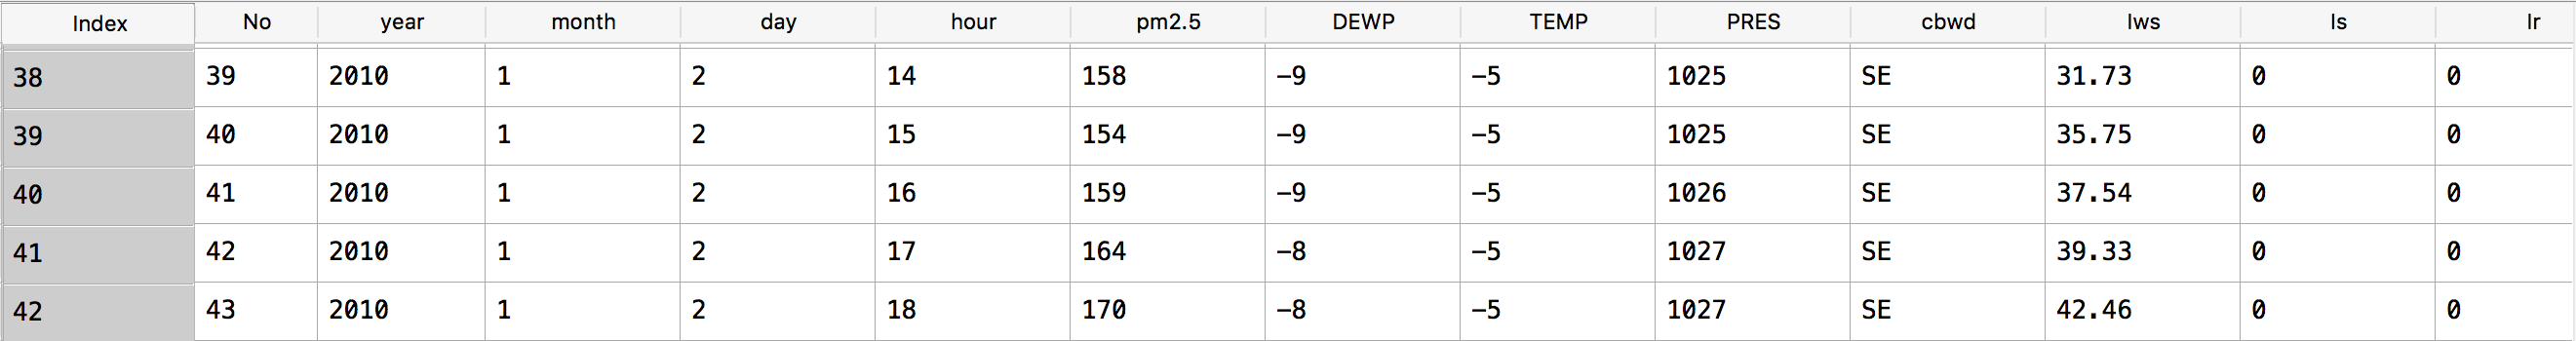

O atributo `No` é somente a contagem de registros (como uma chave primária), o `year`, `month`, `day` e `hour` indicam a dimensão temporal (de hora em hora); o atributo `pm2.5` diz respeito ao nível de poluição (que faremos a previsão) e por fim, todos os outros atributos serão os previsores. Baseado nos atributos previsores, a ideia é indicar o nível de poluição em uma determinada hora.

Siga as seguintes dicas para essa atividade:

- Use a função `dropna()` para excluir valores faltantes

- Os atributos `No`, `year`, `month`, `day`, `hour` e `cbwd` devem ser excluídos, pois em uma série temporal essas informações não são importantes (o `cbwd` é somente um campo string)

- Este é um problema com uma única saída (`pm2.5`) e múltiplos previsores

- Você pode testar com vários valores de intervalos de tempo (começando com 10, por exemplo)

- Você pode optar por dividir a base de dados entre treinamento e teste ou usar a própria base de dados de treinamento (em nossa implementação usamos a própria base de treinamento)

Depois de treinar a rede neural, gere o gráfico para visualizar os resultados das previsões. Abaixo você pode visualizar o gráfico com os nossos resultados

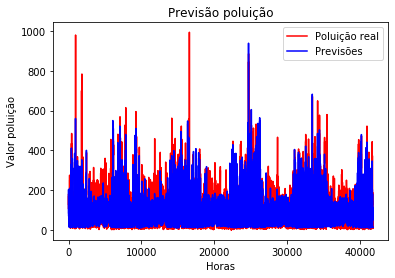

In [ ]:
#!pip install torch==1.4.0

## Etapa 1: Importação das bibliotecas

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [3]:
df = pd.read_csv('/content/poluicao.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
df.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [5]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.5+ MB


In [8]:
df.drop(['No', 'year','month','day','hour','cbwd'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0


In [64]:
data_raw = df.values

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data_raw)

In [23]:
data_scaled.shape

(41757, 7)

In [33]:
X, y = [], []

for i in range(10, data_scaled.shape[0]):
  X.append(data_scaled[i-10:i, 1:])
  y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

In [34]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [35]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

## Etapa 3: Construção da rede neural recorrente

In [36]:
class Reg_LSTM(nn.Module):
  def __init__(self):
    super(Reg_LSTM, self).__init__()

    self.lstm0 = nn.LSTM(input_size=6, hidden_size=100)
    self.lstm1 = nn.LSTM(100, 50)
    self.lstm2 = nn.LSTM(50,50, dropout=0.3, num_layers=2)
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(in_features=50, out_features=1)

  def forward(self, X):
    X = X.permute(1,0,2)
    X, _ = self.lstm0(X)
    X = self.dropout(X)
    X, _ = self.lstm1(X)
    X = self.dropout(X)
    X, _ = self.lstm2(X)    
    X = self.dropout(X)
    X = self.linear(X)

    return X

In [37]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [56]:
reg = Reg_LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters())
reg.to(device)

Reg_LSTM(
  (lstm0): LSTM(6, 100)
  (lstm1): LSTM(100, 50)
  (lstm2): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Etapa 4: Treinamento do modelo

In [57]:
# Variáveis para o callback
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

# Inicializando o custo inicial para usar o callback
min_loss = np.inf

In [58]:
arr_loss, arr_mae = [], []
for epoch in range(200):

  run_loss = 0.
  run_mae = 0.

  for i, data in enumerate(loader):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = reg(inputs)
    outputs = outputs[-1]
    outputs = outputs.view(*labels.shape)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    run_loss += loss.item()
    mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                              outputs.detach().cpu().numpy().flatten())
    
    run_mae += mae

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} | MAE {:03.5f}' \
          .format(epoch+1, i+1, len(loader), loss, mae), end='\r')
    
  run_loss /= len(loader)
  run_mae /= len(loader)
  arr_loss.append(run_loss)
  arr_mae.append(run_mae)
  print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} | MAE {:03.6f}      ' \
        .format(epoch+1, run_loss, run_mae))


  # SALVAR O MODELO
  if run_loss < min_loss:
    print('** Custo reduzido de {:03.6f} >>> {:03.6f} ... SALVANDO CHECKPOINT\n' \
          .format(min_loss, run_loss))
    torch.save(reg.state_dict(), 'checkpoint.pth')
    min_loss = run_loss
    es_patience = 0
    rlr_patience = 0

  else:
    print('**Custo não reduziu, não salva checkpoint\n')
    # OS DEMAIS PARÂMETROS SÓ SERÃO CONSIDERADOS SE O CUSTO NÃO TIVER
    # PARADA ANTECIPADA
    if run_loss - min_loss > ES_MIN_DELTA:
      es_patience += 1

      if es_patience == ES_PATIENCE:
        print('--Critério de parada antecipada alcaçado, parando o treinamento.')
        break

    # REDUZIR A TAXA DE APRENDIZAGEM
    rlr_patience += 1
    if rlr_patience == RLR_PATIENCE:
      print('--Critério de redução de taxa de aprendizagem alcançado, reduzindo LR.')
      for param_group in optimizer.param_groups:
        param_group['lr'] *= RLR_FACTOR
      
      rlr_patience = 0

ÉPOCA   1 FINALIZADA: custo 0.007345 | MAE 0.062291      
** Custo reduzido de inf >>> 0.007345 ... SALVANDO CHECKPOINT

ÉPOCA   2 FINALIZADA: custo 0.006017 | MAE 0.055312      
** Custo reduzido de 0.007345 >>> 0.006017 ... SALVANDO CHECKPOINT

ÉPOCA   3 FINALIZADA: custo 0.005564 | MAE 0.052736      
** Custo reduzido de 0.006017 >>> 0.005564 ... SALVANDO CHECKPOINT

ÉPOCA   4 FINALIZADA: custo 0.005368 | MAE 0.051465      
** Custo reduzido de 0.005564 >>> 0.005368 ... SALVANDO CHECKPOINT

ÉPOCA   5 FINALIZADA: custo 0.005297 | MAE 0.050982      
** Custo reduzido de 0.005368 >>> 0.005297 ... SALVANDO CHECKPOINT

ÉPOCA   6 FINALIZADA: custo 0.005185 | MAE 0.050414      
** Custo reduzido de 0.005297 >>> 0.005185 ... SALVANDO CHECKPOINT

ÉPOCA   7 FINALIZADA: custo 0.005104 | MAE 0.049941      
** Custo reduzido de 0.005185 >>> 0.005104 ... SALVANDO CHECKPOINT

ÉPOCA   8 FINALIZADA: custo 0.005114 | MAE 0.049935      
**Custo não reduziu, não salva checkpoint

ÉPOCA   9 FINALIZADA: 

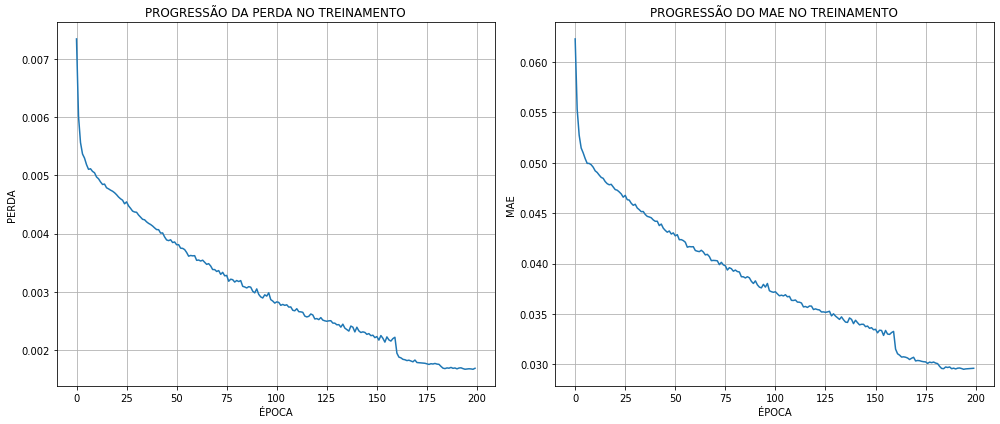

In [59]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].plot(arr_loss, label='Perda')
ax[0].set(xlabel='ÉPOCA', ylabel='PERDA', title='PROGRESSÃO DA PERDA NO TREINAMENTO')
ax[0].grid()

ax[1].plot(arr_mae, label='MAE')
ax[1].set(xlabel='ÉPOCA', ylabel='MAE', title='PROGRESSÃO DO MAE NO TREINAMENTO')
ax[1].grid()

plt.tight_layout();

## Etapa 5: Processamento da base de teste

## Etapa 6: Previsões

In [60]:
reg.eval()
predicted = reg(X.to(device))

In [61]:
predicted = predicted[-1]
predicted = predicted.detach().cpu().numpy().reshape(-1,1)

In [65]:
y_scaler = MinMaxScaler()
y_scaler.fit(data_raw[:,0].reshape(-1,1))
predicted = y_scaler.inverse_transform(predicted)

In [66]:
data_raw[:,0].reshape(-1,1).mean(), predicted.mean()

(98.61321455085375, 98.43386)

In [70]:
mean_absolute_error(data_raw[10:,0].reshape(-1,1), predicted)

25.233199245393394

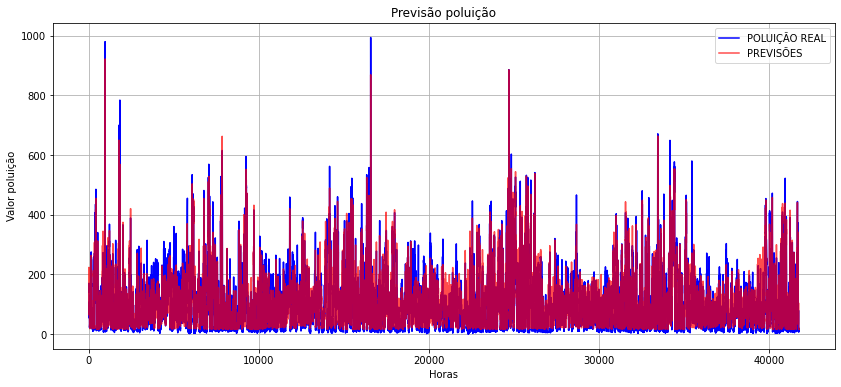

In [76]:
plt.figure(figsize=(14,6))
plt.plot(data_raw[10:,0].reshape(-1,1), color='b', label= 'POLUIÇÃO REAL')
plt.plot(predicted, alpha=0.7, color='r', label='PREVISÕES')
plt.title('Previsão poluição')
plt.xlabel('Horas')
plt.ylabel('Valor poluição')
plt.legend()
plt.grid()
plt.show()